## Import libraries

In [11]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping
import keras.utils as image
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin

## Define image and model parameters

In [3]:
image_size = (150, 150)
batch_size = 32
epochs = 10
k_folds = 5

## Define train, validation, and test directories

In [4]:
train_dir = '../data/chest_xray/train'
val_dir =  '../data/chest_xray/val'
test_dir = '../data/chest_xray/test'

## Data exploration

### Organise datasets

In [6]:
labels = ['NORMAL', 'PNEUMONIA']

def load_labels(directory, dataset):
  for label in labels:
    path = os.path.join(directory, label)
    for image in os.listdir(path):
      try:
        dataset.append(label)
      except Exception as e:
        pass

y_train = []
y_valid = []
y_test = []

load_labels(train_dir, y_train)
load_labels(val_dir, y_valid)
load_labels(test_dir, y_test)

### Visualize datasets

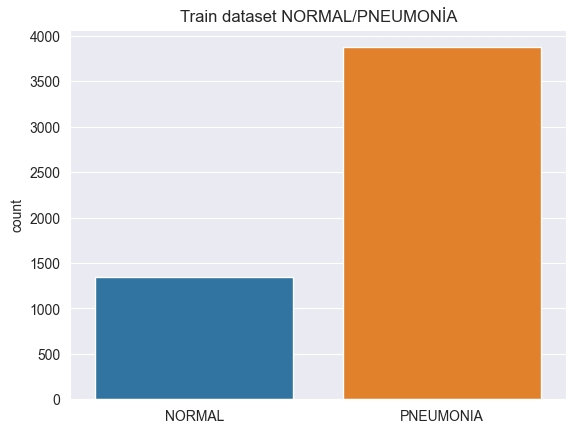

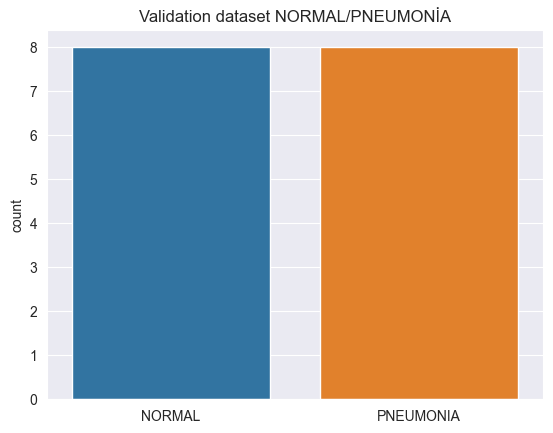

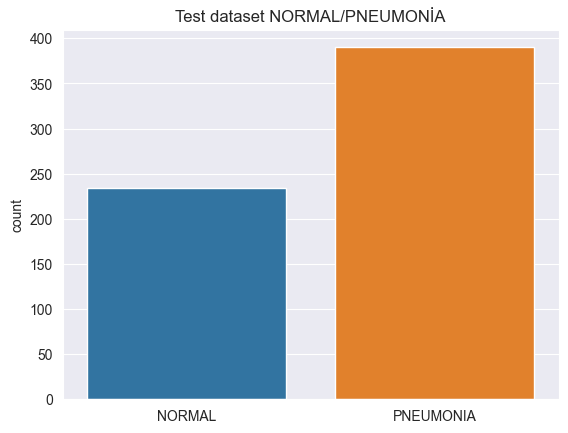

In [5]:
sns.countplot(x=y_train)
plt.title("Train dataset NORMAL/PNEUMONİA")
plt.show()

sns.countplot(x=y_valid)
plt.title("Validation dataset NORMAL/PNEUMONİA")
plt.show()

sns.countplot(x=y_test)
plt.title("Test dataset NORMAL/PNEUMONİA")
plt.show()

## Data augmentation

In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Define CNN model

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Extract the image data and labels from the generator

In [8]:
X_train = []
y_train = []
for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    X_train.append(batch_x)
    y_train.append(batch_y)
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

## Define a wrapper class to convert Keras model into scikit-learn estimator

In [9]:
class KerasEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        self.classes_ = np.array([0, 1])  # Assuming binary classification

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)

    def decision_function(self, X):
        return self.model.predict(X)

## Wrap the Keras model using the wrapper class

In [10]:
estimator = KerasEstimator(model)

## Perform cross validation

In [11]:
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
y_scores = cross_val_predict(
    estimator,
    X_train,
    y_train,
    cv=kfold,
    method='decision_function'
)
roc_auc = roc_auc_score(y_train, y_scores)

print(f"Cross-Validation ROC-AUC score: {np.mean(roc_auc):.4f}")

33/33 [==============================] - 4s 111ms/step
Cross-Validation ROC-AUC score: 0.9387


## Apply EarlyStopping

In [12]:
early_stopping = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)

## Train model

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
163/163 [==============================] - 124s 753ms/step - loss: 0.4085 - accuracy: 0.8276
Epoch 2/10
163/163 [==============================] - 121s 741ms/step - loss: 0.2348 - accuracy: 0.9084
Epoch 3/10
163/163 [==============================] - 115s 706ms/step - loss: 0.2176 - accuracy: 0.9153
Epoch 4/10
163/163 [==============================] - 115s 704ms/step - loss: 0.1852 - accuracy: 0.9252
Epoch 5/10
163/163 [==============================] - 115s 705ms/step - loss: 0.1597 - accuracy: 0.9398
Epoch 6/10
163/163 [==============================] - 115s 704ms/step - loss: 0.1470 - accuracy: 0.9408
Epoch 7/10
163/163 [==============================] - 115s 707ms/step - loss: 0.1414 - accuracy: 0.9452
Epoch 8/10
163/163 [==============================] - 115s 705ms/step - loss: 0.1327 - accuracy: 0.9517
Epoch 9/10
163/163 [==============================] - 115s 706ms/step - loss: 0.1314 - accuracy: 0.9502
Epoch 10/10
163/163 [==============================] - 115s 704m

## Plot train loss and train accuracy

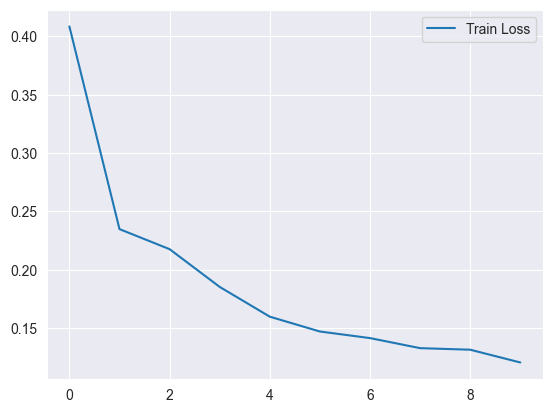

In [14]:
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.legend()
plt.show()

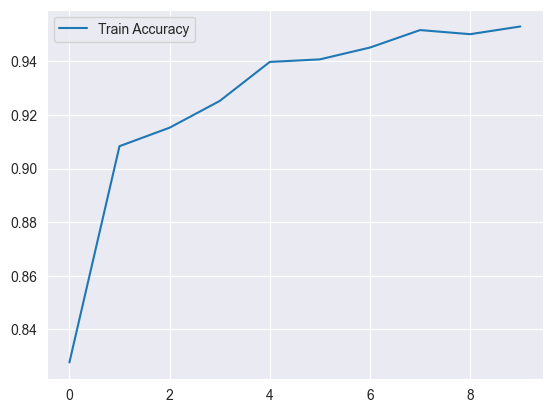

In [15]:
plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.legend()
plt.show()

## Evaluate the model on the test set

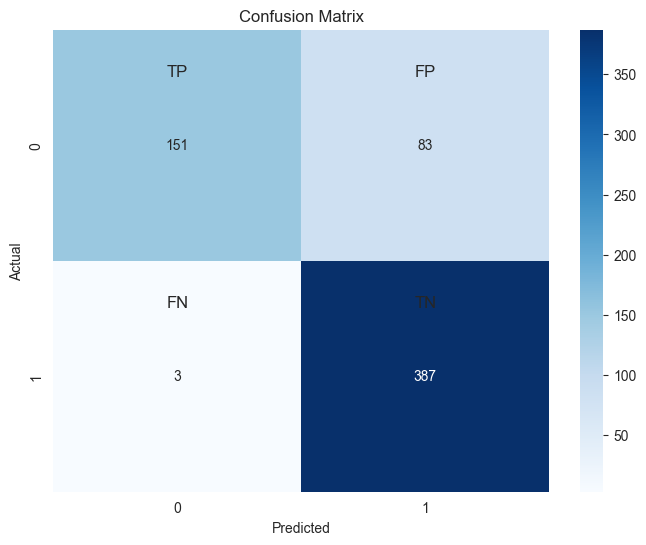

Accuracy: 0.8622
Precision: 0.8234
Recall: 0.9923
ROC-AUC: 0.9591


In [24]:
y_test_true = test_generator.classes
y_test_pred_prob = model.predict(test_generator)
y_test_pred = np.round(y_test_pred_prob)

# Create confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Extract TN, FN, FP, TP from confusion matrix
tn, fp, fn, tp = cm.ravel()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Add TP, FP, FN, TN labels
plt.text(0.5, 0.2, 'TP', fontsize=12, ha='center')
plt.text(1.5, 0.2, 'FP', fontsize=12, ha='center')
plt.text(0.5, 1.2, 'FN', fontsize=12, ha='center')
plt.text(1.5, 1.2, 'TN', fontsize=12, ha='center')

plt.show()

accuracy_score = metrics.accuracy_score(y_test_true, y_test_pred)
precision_score = tp / (tp + fp)
recall_score = tp / (tp + fn)
roc_auc_score = metrics.roc_auc_score(y_test_true, y_test_pred_prob)

print(f"Accuracy: {accuracy_score:.4f}")
print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")
print(f"ROC-AUC: {roc_auc_score:.4f}")

## Predict single image

In [17]:
# Load and preprocess the image for prediction
image_path = '../data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'
img = image.load_img(image_path, target_size=image_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize the image

# Make the prediction
prediction = model.predict(img_array)

# Convert the prediction to a human-readable label
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
if prediction[0][0] <= 0.5:
    predicted_label = class_labels[0]
else:
    predicted_label = class_labels[1]

print(f"Prediction: {predicted_label}")

1/1 [==============================] - 0s 72ms/step
Prediction: PNEUMONIA
